In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.impute import MissingIndicator 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from operator import attrgetter
import matplotlib.colors as mcolors

# Customer analysis

In this exercise, you work for a consulting firm as data analyst. One of your clients asked for help to understand its customer buying behavior. 

You dispose of a dataset from its e-commerce website with 13 features : 

- order_id : ID if the order
- order_status : Status of the order
- order_purchase_timestamp : Timestamp of the purchase
- order_delivered_customer_date : Timestamp of the delivery to the customer
- payment_type : Method of payment
- payment_installments : Number of payments for this purchase (does NOT affect the payment value)
- payment_value : Total amount of the payment
- review_score : Score given by the client, ranges from 1 to 5
- customer_unique_id : ID of the customer who purchased
- customer_zip_code_prefix : Zip code of the customer
- customer_city : City of the customer
- customer_state : State of the customer
- product_category_name_english : Name of the product category in English

With this data, you have to analyze customer behavior with two techniques:

- Customer segmentation with RFM
- Cohort analysis from Sept 2016 to October 2018.

At the end, you have to present your analysis with actionable insights to improve the customer relationship of your client. 

# Understanding RFM Segmentation 

❓ What are the 3 metrics used in an RFM Segmentation? (hint : What does RFM stand for?) 

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

❓ Can you summarize what each metric measures in one sentence?

Each metric trying to measures the behavior of a client 

❓ What data / or type of data do you need for each metric ? 

Récence : order_purchase_timestamp  
Fréquence : order_id	
Montant : payment_installments

Let's explore the dataset!

# Exploratory Data Analysis

Load the dataset and start an Exploratory Data Analysis

In [2]:
df = pd.read_csv('db_customers.csv')
df.shape

(105383, 15)

❓ Which features should be formated in datetime ? 
Convert them

In [3]:
from datetime import datetime 
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(pd.to_datetime)
date_format = "%m/%d/%Y"
df.dtypes

Unnamed: 0                                int64
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date            object
payment_type                             object
payment_installments                    float64
payment_value                           float64
review_score                              int64
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
product_category_name_english            object
dtype: object

❓ Which features are Categorical ? List the unique values on these features.

In [4]:
# Unique values for categorical features
order_status=df['order_status'].unique()
payment_type=df['payment_type'].unique()
customer_city=df['customer_city'].unique()
customer_state=df['customer_state'].unique()
product_category_name_english=df['product_category_name_english'].unique()

print(f'order status: {order_status}')
print(f'payment_type: {payment_type}')
print(f'order status: {customer_city}')
print(f'order status: {customer_state}')
print(f'order status: {product_category_name_english}')

order status: ['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']
payment_type: ['credit_card' 'voucher' 'boleto' 'debit_card' 'not_defined' nan]
order status: ['sao paulo' 'barreiras' 'vianopolis' ... 'messias targino'
 'campo do tenente' 'nova vicosa']
order status: ['SP' 'BA' 'GO' 'RN' 'PR' 'RS' 'RJ' 'MG' 'SC' 'RR' 'PE' 'TO' 'CE' 'DF'
 'SE' 'MT' 'PB' 'PA' 'RO' 'ES' 'AP' 'MS' 'MA' 'PI' 'AL' 'AC' 'AM']
order status: ['housewares' 'perfumery' 'auto' 'pet_shop' 'stationery' nan
 'furniture_decor' 'office_furniture' 'garden_tools'
 'computers_accessories' 'bed_bath_table' 'toys'
 'construction_tools_construction' 'telephony' 'health_beauty'
 'electronics' 'baby' 'cool_stuff' 'watches_gifts' 'air_conditioning'
 'sports_leisure' 'books_general_interest' 'small_appliances' 'food'
 'luggage_accessories' 'fashion_underwear_beach' 'christmas_supplies'
 'fashion_bags_accessories' 'musical_instruments'
 'construction_tools_lights' 'books_technical' 'cos

❓ Check for missing values. What do you notice ? 


In [5]:
df.isnull().sum()

Unnamed: 0                          0
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_delivered_customer_date    3159
payment_type                        1
payment_installments                1
payment_value                       1
review_score                        0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
product_category_name_english    2410
dtype: int64

❓ Can you find an explanation for the missing `order_delivered_customer_date` ? 
(hint : Check for non delivered orders)

In [6]:
df['order_status'].value_counts()

delivered      102225
shipped          1180
canceled          669
unavailable       651
invoiced          330
processing        321
created             5
approved            2
Name: order_status, dtype: int64

❓ What are the proportions of each `order_status` ? 

In [7]:
df['order_status'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

delivered      97.0%
shipped         1.1%
canceled        0.6%
unavailable     0.6%
invoiced        0.3%
processing      0.3%
created         0.0%
approved        0.0%
Name: order_status, dtype: object

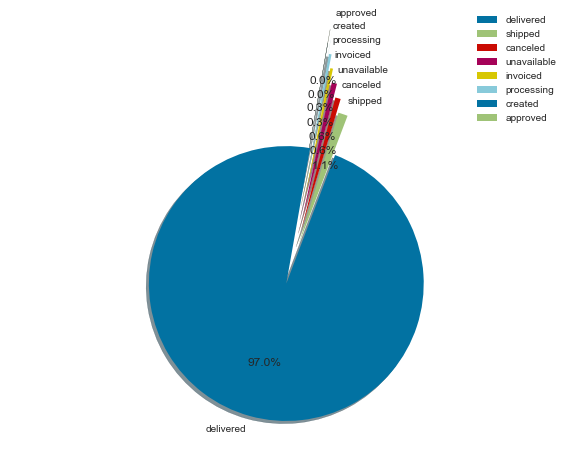

In [8]:
labels = 'delivered', 'shipped', 'canceled', 'unavailable','invoiced','processing','created','approved'
sizes = df['order_status'].value_counts()
explode = (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8)

fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=80)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()

❓ Which `order_status` do you think should be removed from the analysis

delivered and shipped

In [9]:
df_new = df[(df['order_status'] != "delivered") & (df['order_status'] != "shipped")].index
df.drop(df_new , inplace=True)
df['order_status'].value_counts()

delivered    102225
shipped        1180
Name: order_status, dtype: int64

In [10]:
df_use = df[['customer_unique_id','order_id','order_purchase_timestamp','payment_value']]
df

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,payment_type,payment_installments,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,credit_card,1.0,18.12,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares
1,1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,voucher,1.0,2.00,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares
2,2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,voucher,1.0,18.59,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares
3,3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,boleto,1.0,141.46,4,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,perfumery
4,4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,credit_card,3.0,179.12,5,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105378,105378,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-17 15:08:01,credit_card,3.0,85.08,5,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,health_beauty
105379,105379,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-28 17:37:56,credit_card,3.0,195.00,4,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,baby
105380,105380,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-09-21 11:24:17,credit_card,5.0,271.01,5,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,home_appliances_2
105381,105381,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,credit_card,4.0,441.16,2,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,computers_accessories


❓ What feature would you choose in the e-commerce dataset provided? 

payment_value

❓ What method would you use to group the data? 

groupby

❓ What feature would you use to group the data? 

customer_unique_id

Group the data. (Hint: you can carry out the grouping one by one and then merge, or even better use the .agg method and get a robust grouping in one line of code)

What type of data is the R supposed to be? Is it in the right format? (Hint : investigate the difference between `datetime` and `timedelta`) 

order_purchase_timestamp

So there is one more step to carry out before the data is ready : Calculate the recency base on the date of the purchase

❓ What is the date of the least purchase?

In [11]:
df['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

❓What is the date of the most recent purchase?

In [12]:
df['order_purchase_timestamp'].max()

Timestamp('2018-09-03 09:06:57')

❓How would you calculate the recency? (hint: what date would you use to compare with the purchase date? Today? probably not...)

In [13]:
from datetime import datetime 
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(pd.to_datetime)
date_format = "%m/%d/%Y"
a = df['order_purchase_timestamp']
b = max(df['order_purchase_timestamp'])
df['recence'] = b-a
df['recence'] = df['recence'].astype('timedelta64[D]')
recence = df.groupby('customer_unique_id')['recence'].min()
recence = pd.DataFrame(recence).reset_index()

Create a feature calculating the difference between `the most recent purchased + 1 day`, and `order_purchase_timestamp`.

In [14]:
recence

,customer_unique_id,recence
0,0000366f3b9a7992bf8c76cfdf3221e2,115.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0
2,0000f46a3911fa3c0805444483337064,541.0
3,0000f6ccb0745a6a4b88665a16c9f078,325.0
4,0004aac84e0df4da2b147fca70cf8255,292.0
...,...,...
94394,fffcf5a5ff07b0908bd4e2dbc735a684,451.0
94395,fffea47cd6d3cc0a88bd621562a9d061,266.0
94396,ffff371b4d645b6ecea244b27531430a,572.0
94397,ffff5962728ec6157033ef9805bacc48,123.0


Now that you have created a new dataset with the right columns, explore it to understand what you created.

❓Which column is the R? The F? The M?

In [15]:
montant = df.groupby('customer_unique_id')['payment_value'].sum()
montant =pd.DataFrame(montant).reset_index()
montant

,customer_unique_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
94394,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
94395,fffea47cd6d3cc0a88bd621562a9d061,84.58
94396,ffff371b4d645b6ecea244b27531430a,112.46
94397,ffff5962728ec6157033ef9805bacc48,133.69


In [16]:
frequence = df.groupby('customer_unique_id')['order_id'].count()
frequence =pd.DataFrame(frequence).reset_index()
frequence

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94394,fffcf5a5ff07b0908bd4e2dbc735a684,1
94395,fffea47cd6d3cc0a88bd621562a9d061,1
94396,ffff371b4d645b6ecea244b27531430a,1
94397,ffff5962728ec6157033ef9805bacc48,1


In [17]:
df_rfm = recence.merge(montant, left_on='customer_unique_id',right_on = 'customer_unique_id',how ='left')
df_rfm= df_rfm.merge(frequence, left_on='customer_unique_id',right_on = 'customer_unique_id',how ='left')

In [18]:
df_rfm.columns = ['customer_unique_id','recence','montant','frequence']

In [19]:
df_rfm.head()

,customer_unique_id,recence,montant,frequence
0,0000366f3b9a7992bf8c76cfdf3221e2,115.0,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,27.19,1
2,0000f46a3911fa3c0805444483337064,541.0,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,325.0,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,292.0,196.89,1


Now for each metric independantly, build clutsers (Hint 1: you can use `.describe()` to have insights about each metrics. Hint 2: Don't choose more than 3 clusters)

In [20]:
df_rfm.describe()

,recence,montant,frequence
count,94399.000000,94399.000000,94399.000000
mean,241.864162,168.250134,1.095404
std,152.723176,232.880460,0.530304
min,0.000000,0.000000,1.000000
25%,118.000000,63.110000,1.000000
50%,223.000000,108.100000,1.000000
75%,351.000000,184.590000,1.000000
max,728.000000,13664.080000,54.000000


In [21]:
###Calculating quantile values
quintiles = df_rfm[['recence', 'frequence', 'montant']].quantile([.1, .25, .3, .4, .5, .6, .7, .8, .9]).to_dict()
###Benchmark to give score for recency indicator
def r_score(r):
    if r <= quintiles['recence'][.25]:
        return 1 
    elif r > quintiles['recence'][.25] and r <=quintiles['recence'][.7]:
        return 2
    else: 
        return 3
###Benchmark to give score for frequency & monetary indicator.   
def f_score(f): 
    if f == df_rfm['frequence'][1]:
        return 2
    else:
        return 1
def m_score(m):
    if m <= df_rfm['montant'][118]:
        return 3
    elif m >= df_rfm['montant'][118] and m <= df_rfm['montant'][245]:
        return 2
    else:
        return 1

In [22]:
df_rfm['r_score'] = df_rfm.recence.apply(lambda x: r_score(x))
df_rfm['f_score'] = df_rfm.frequence.apply(lambda x: f_score(x))
df_rfm['m_score'] = df_rfm.montant.apply(lambda x: m_score(x))
df_rfm['rfm'] = df_rfm['r_score'].map(str)+df_rfm['f_score'].map(str) + df_rfm['m_score'].map(str)
df_rfm.head()

,customer_unique_id,recence,montant,frequence,r_score,f_score,m_score,rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,115.0,141.90,1,1,2,1,121
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,27.19,1,1,2,3,123
2,0000f46a3911fa3c0805444483337064,541.0,86.22,1,3,2,2,322
3,0000f6ccb0745a6a4b88665a16c9f078,325.0,43.62,1,3,2,2,322
4,0004aac84e0df4da2b147fca70cf8255,292.0,196.89,1,2,2,1,221


In [23]:
df_rfm['rfm'].value_counts()

222    20832
221    16777
322    14202
122    11402
321    10770
121     9444
223     2048
211     1847
323     1388
123     1252
311     1218
111     1157
212      821
312      675
112      422
213       71
313       46
113       27
Name: rfm, dtype: int64

In [41]:
df_rfm['rfm'] = df_rfm['rfm'].astype(float)
df_rfm['rfm'].nunique()

18

In [25]:
#Assign fidelity level to each customer

fidelity_level = ['Champion','Loyal','New Customers','Needs attention','Lost']
score_cuts = pd.qcut(df_rfm.rfm, q=5,labels = fidelity_level)
df_rfm['RFM_Fidelity_Level'] = score_cuts.values
df_rfm.reset_index()
# RFMScores['RFMgroup'].value_counts(ascending=False)


,index,customer_unique_id,recence,montant,frequence,r_score,f_score,m_score,rfm,RFM_Fidelity_Level
0,0,0000366f3b9a7992bf8c76cfdf3221e2,115.0,141.90,1,1,2,1,121.0,Champion
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,27.19,1,1,2,3,123.0,Loyal
2,2,0000f46a3911fa3c0805444483337064,541.0,86.22,1,3,2,2,322.0,Lost
3,3,0000f6ccb0745a6a4b88665a16c9f078,325.0,43.62,1,3,2,2,322.0,Lost
4,4,0004aac84e0df4da2b147fca70cf8255,292.0,196.89,1,2,2,1,221.0,Loyal
...,...,...,...,...,...,...,...,...,...,...
94394,94394,fffcf5a5ff07b0908bd4e2dbc735a684,451.0,2067.42,1,3,2,1,321.0,Needs attention
94395,94395,fffea47cd6d3cc0a88bd621562a9d061,266.0,84.58,1,2,2,2,222.0,New Customers
94396,94396,ffff371b4d645b6ecea244b27531430a,572.0,112.46,1,3,2,2,322.0,Lost
94397,94397,ffff5962728ec6157033ef9805bacc48,123.0,133.69,1,2,2,1,221.0,Loyal


In [40]:
df_rfm['rfm'].value_counts(normalize=True)*100

222.0    22.068030
221.0    17.772434
322.0    15.044651
122.0    12.078518
321.0    11.409019
121.0    10.004343
223.0     2.169515
211.0     1.956589
323.0     1.470355
123.0     1.326285
311.0     1.290268
111.0     1.225649
212.0     0.869713
312.0     0.715050
112.0     0.447039
213.0     0.075213
313.0     0.048729
113.0     0.028602
Name: rfm, dtype: float64

In [27]:
df_rfm['RFM_Fidelity_Level'].value_counts()

Champion           22452
New Customers      20832
Loyal              20768
Lost               15590
Needs attention    14757
Name: RFM_Fidelity_Level, dtype: int64

Now that you have clusters for each category, explain the different buying behaviors

# Working with cohorts

❓What is a cohort? 

Cohort analysis allows you to ask targeted questions and make informed product decisions that reduce churn and increase revenue.

❓Why is it interesting to analyse cohorts ? 

Cohort analysis is a type of behavioral analytics in which you group your users based on their shared traits to better track and understand their actions.

❓What data (already existing in the original dataset) do we need to build a cohort? 

order_purchase_timestamp  
customer_unique_id  
order_id

Build a new df with just these 3 features

In [28]:
df_c = df[['customer_unique_id','order_id','order_purchase_timestamp']]
df.dtypes

Unnamed: 0                                int64
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date            object
payment_type                             object
payment_installments                    float64
payment_value                           float64
review_score                              int64
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
product_category_name_english            object
recence                                 float64
dtype: object

In [29]:
m = pd.DatetimeIndex(df_c['order_purchase_timestamp'])
df_c['order_months'] = m.to_period('M')

<ipython-input-29-02ed7b82304b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['order_months'] = m.to_period('M')


Using the `pandas.Serie.dt.to_period()` methode, create a new feature converting `order_purchase_timestamp` in months

Create a new feature called `cohort` by grouping the previous df by `customer_unique_id`, and tranforming it's minimum value in months (with the same `pandas.Serie.dt.to_period()` as before)

In [30]:
# For the teachers, To filter by only the customer that have done 2 or more purchases
df_more =pd.DataFrame(df_c.groupby('customer_unique_id').size()[df_c.groupby('customer_unique_id').size() > 1])
df_c = df_c.merge(df_more, how='left', on='customer_unique_id').rename(columns={0:'na'})

df_c = df_c[df_c['na'].notna()]

In [31]:
df_c['cohort'] = df_c.groupby('customer_unique_id')['order_purchase_timestamp'] \
                 .transform('min') \
                 .dt.to_period('M') 
df_c

,customer_unique_id,order_id,order_purchase_timestamp,order_months,na,cohort
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,4.0,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,4.0,2017-09
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,4.0,2017-09
10,299905e3934e9e181bfb2e164dd4b4f8,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29 11:55:02,2017-07,2.0,2017-07
11,299905e3934e9e181bfb2e164dd4b4f8,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29 11:55:02,2017-07,2.0,2017-07
...,...,...,...,...,...,...
103389,9e4accf95024aa6565ca1efcadb96752,19dba6d1e58b04e7fc820558a38ea398,2018-05-12 13:42:24,2018-05,2.0,2017-09
103395,c716cf2b5b86fb24257cffe9e7969df8,9115830be804184b91f5c00f6f49f92d,2017-10-04 19:57:37,2017-10,2.0,2017-10
103396,c716cf2b5b86fb24257cffe9e7969df8,9115830be804184b91f5c00f6f49f92d,2017-10-04 19:57:37,2017-10,2.0,2017-10
103397,e03dbdf5e56c96b106d8115ac336f47f,aa04ef5214580b06b10e2a378300db44,2017-01-27 00:30:03,2017-01,2.0,2017-01


In [32]:
df_c = df_c.dropna()

Now groupby `['cohort', 'order_month']` and aggregate by `nunique()` `customer_unique_id`

Finally, create a feature called `['period_number']` where you substract the `cohort` to the `order_month` and get the `'n'` attribute thanks to the `operator.attrgetter` method

In [33]:
df_cohort = df_c.groupby(['cohort', 'order_months']) \
              .agg(n_customers=('customer_unique_id', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_c.order_months - df_c.cohort).apply(attrgetter('n'))
df_cohort

,cohort,order_months,n_customers,period_number
0,2016-10,2016-10,24,1.0
1,2016-10,2017-04,1,1.0
2,2016-10,2017-07,1,1.0
3,2016-10,2017-09,1,NaN
4,2016-10,2017-11,1,NaN
...,...,...,...,...
214,2018-06,2018-08,16,NaN
215,2018-07,2018-07,295,NaN
216,2018-07,2018-08,31,NaN
217,2018-08,2018-08,229,NaN


Explore a cohort (for example 2017-01) and try to understand what it shows

In [34]:
df_cohort[df_cohort['cohort'] == '2017-01']

,cohort,order_months,n_customers,period_number
11,2017-01,2017-01,77,0.0
12,2017-01,2017-02,3,NaN
13,2017-01,2017-03,2,NaN
14,2017-01,2017-04,1,NaN
15,2017-01,2017-05,3,NaN
16,2017-01,2017-06,1,NaN
17,2017-01,2017-07,3,20.0
18,2017-01,2017-08,1,6.0
19,2017-01,2017-09,1,NaN
20,2017-01,2017-11,3,NaN


Pivot the DataFrame using the methode : `DataFrame.pivot_table` (hint : use `'cohort'` as `index`, `'period_number'` as columns, and `'n_customers'` as `values`)

In [35]:
df_pivot = df_cohort.pivot_table(index='cohort',values='n_customers',columns='period_number')

Now divide all the values (except your column 0) by the column 0 and name this new DataFrame `retention_matrix`

In [36]:
cohort_size = df_pivot.iloc[:,0]
retention_matrix = df_pivot.divide(cohort_size, axis = 0)
retention_matrix

period_number,0.0,1.0,5.0,6.0,20.0
cohort,,,,,
2016-10,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,NaN,NaN,NaN,NaN
2017-01,1.0,NaN,NaN,0.046512,0.139535
2017-03,1.0,NaN,NaN,NaN,NaN
2017-04,1.0,0.181818,NaN,NaN,NaN
2017-05,1.0,NaN,NaN,NaN,NaN
2017-06,1.0,NaN,NaN,NaN,NaN
2017-07,1.0,NaN,NaN,NaN,NaN
2017-08,1.0,NaN,NaN,NaN,NaN


Plot your `retention matrix` using the code below : 

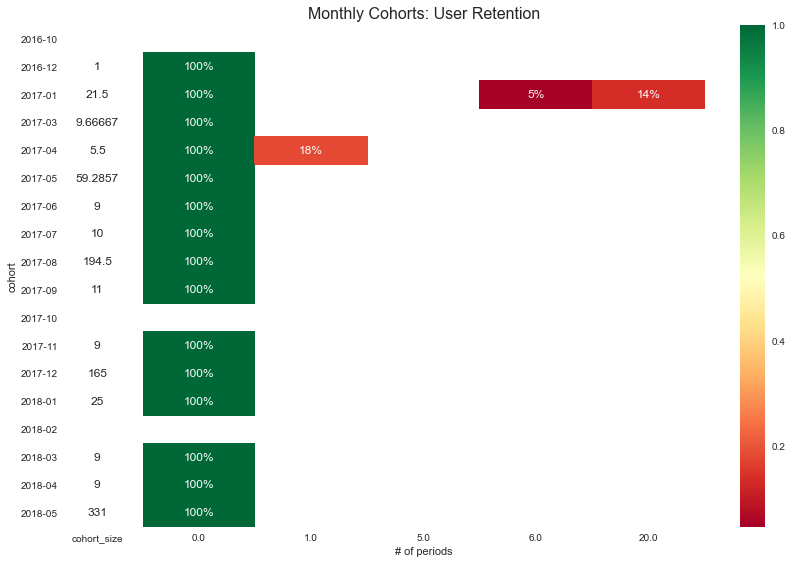

In [37]:

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()


What do you notice? 

They buy just once 

How could we have know that before? (hint : Calculate the percentage of customers who have ordered more than once)

Here is the code for the analysis of customers who have bought more than once : 

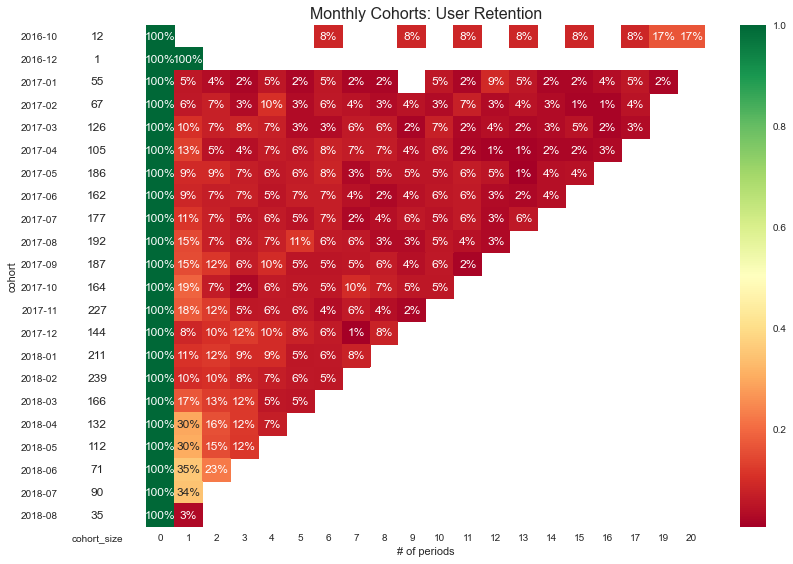

In [38]:
#start from your df created doing the RFM segmentation
df_c = df[['customer_unique_id', 'order_id',
           'order_purchase_timestamp']].drop_duplicates()

df_c['order_month'] = df_c['order_purchase_timestamp'].dt.to_period('M')

df_more = pd.DataFrame(df_c.groupby('customer_unique_id').size()[
                       df_c.groupby('customer_unique_id').size() > 1])

df_c = df_c.merge(df_more, how='left', on='customer_unique_id').rename(
    columns={0: 'na'})

df_c = df_c[df_c['na'].notna()]
df_c['cohort'] = df_c.groupby('customer_unique_id')['order_purchase_timestamp'] \
    .transform('min') \
    .dt.to_period('M')

df_cohort = df_c.groupby(['cohort', 'order_month']) \
    .agg(n_customers=('customer_unique_id', 'nunique')) \
    .reset_index(drop=False)
df_cohort['period_number'] = (
    df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
cohort_pivot = df_cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='n_customers')
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={
                           'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(
        columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()